In [1]:
import os, json
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import re
import joblib
import torch
from torch import nn

In [2]:
# Modelo
class NumericTokenizer(nn.Module):
    """Mapea features numéricas a tokens: token_i = x_i * W_i + b_i"""
    def __init__(self, n_features: int, d_token: int):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(n_features, d_token))
        self.bias = nn.Parameter(torch.zeros(n_features, d_token))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, F) -> (B, F, D)
        return x.unsqueeze(-1) * self.weight + self.bias

class FTTransformer(nn.Module):
    def __init__(self, n_features: int, d_token: int, n_layers: int, n_head: int, ff_mult: int, dropout: float):
        super().__init__()
        self.tokenizer = NumericTokenizer(n_features, d_token)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_token))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_head,
            dim_feedforward=d_token * ff_mult,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.LayerNorm(d_token),
            nn.Linear(d_token, d_token),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_token, 1),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        tokens = self.tokenizer(x)                  # (B, F, D)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, D)
        x_tok = torch.cat([cls, tokens], dim=1)    # (B, 1+F, D)
        x_enc = self.encoder(x_tok)                # (B, 1+F, D)
        cls_out = x_enc[:, 0, :]                   # (B, D)
        y = self.head(cls_out).squeeze(-1)         # (B,)
        return y

### SHAP Modelo Base FT-Transformer

In [4]:
VERSION_TAG_FTT = "v1" # ajusta: v1/v2/v3
BASE_FTT = "models_FTT"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_base =df_vcr_c.copy()
obj_cols = df_base.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols) + ["id", "latitud", "longitud"]
df_base = df_base.drop(columns=cols_to_drop)

In [5]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [6]:
# === Preparar datos ===
DF = df_base.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [7]:
# Background y subconjunto a explicar
BG_K = 256
EX_N = min(512, X_std.shape[0])
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [8]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [9]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/512 [00:00<?, ?it/s]

In [14]:
# --- Parámetros SHAP (FTT) ---
TOPK = min(20, len(feat_ftt))  # top-20 o el máximo disponible

# Sanidad de formas
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

imp_ftt = np.mean(np.abs(shap_vals_ftt), axis=0)
order_ftt = np.argsort(imp_ftt)[::-1]
shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
})
print("\n[FTT] Top-20 features por |SHAP|:") 
print(shap_top_ftt.to_string(index=False))


[FTT] Top-20 features por |SHAP|:
             feature  mean_|shap|
        superficie_t     0.566236
               banos     0.228519
     estacionamiento     0.134606
         dormitorios     0.069312
             bodegas     0.051181
             terraza     0.043518
          antiguedad     0.032667
      banos_faltante     0.009310
 antiguedad_faltante     0.008774
                Or_E     0.007594
         Or_Faltante     0.006537
       flag_Semipiso     0.005044
   flag_Departamento     0.004970
                Or_O     0.004874
                Or_S     0.004570
        flag_Premium     0.003464
     flag_Multinivel     0.003438
   flag_Monoambiente     0.003335
dormitorios_faltante     0.003266
                Or_N     0.003252


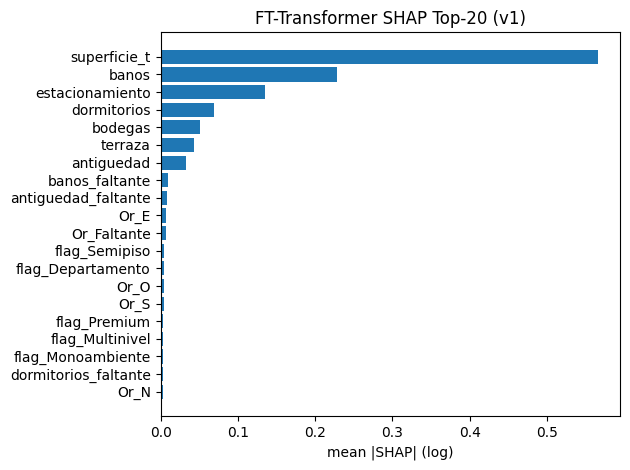

In [13]:
# Gráfico Top-K
plt.figure()
plt.barh(shap_top_ftt["feature"][::-1], shap_top_ftt["mean_|shap|"][::-1])
plt.xlabel("mean |SHAP| (log)"); plt.title(f"FT-Transformer SHAP Top-{TOPK} ({VERSION_TAG_FTT})")
plt.tight_layout(); plt.show()

### SHAP Modelo con coordenadas FT-Transformer

In [3]:
VERSION_TAG_FTT = "v2" # ajusta: v1/v2/v3
BASE_FTT = "models_FTT"

# Configuración básica del dataset
df_vcr_c = pd.read_csv('dataset_vcr_compact.csv')
df_vcr_c = df_vcr_c[df_vcr_c['monto'] < 56000].copy()
df_vcr_c['log_monto']=np.log(df_vcr_c['monto'])

df_coord =df_vcr_c.copy()
obj_cols = df_coord.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_coord = df_coord.drop(columns=cols_to_drop)

In [4]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [5]:
# === Preparar datos ===
DF = df_coord.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [6]:
# Background y subconjunto a explicar
BG_K = 128
EX_N = 256
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [7]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [8]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

Using 128 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/256 [00:00<?, ?it/s]

In [9]:
# --- Parámetros SHAP (FTT) ---
TOPK = min(20, len(feat_ftt))  # top-20 o el máximo disponible

# Sanidad de formas
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

imp_ftt = np.mean(np.abs(shap_vals_ftt), axis=0)
order_ftt = np.argsort(imp_ftt)[::-1]
shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
})
print("\n[FTT] Top-20 features por |SHAP|:") 
print(shap_top_ftt.to_string(index=False))


[FTT] Top-20 features por |SHAP|:
             feature  mean_|shap|
        superficie_t     0.338583
            longitud     0.270303
               banos     0.135221
             latitud     0.115089
     estacionamiento     0.059179
          antiguedad     0.034251
             terraza     0.026687
         dormitorios     0.007862
             bodegas     0.006930
                Or_S     0.004518
                Or_O     0.004502
     flag_Multinivel     0.004352
 antiguedad_faltante     0.004343
      banos_faltante     0.004332
                Or_E     0.003632
   flag_Departamento     0.003483
                Or_N     0.003464
        flag_Premium     0.003419
dormitorios_faltante     0.003037
       flag_Semipiso     0.002865


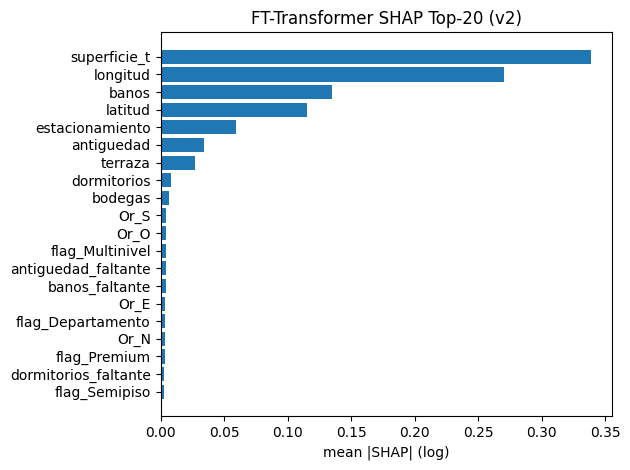

In [10]:
# Gráfico Top-K
plt.figure()
plt.barh(shap_top_ftt["feature"][::-1], shap_top_ftt["mean_|shap|"][::-1])
plt.xlabel("mean |SHAP| (log)"); plt.title(f"FT-Transformer SHAP Top-{TOPK} ({VERSION_TAG_FTT})")
plt.tight_layout(); plt.show()

### SHAP Modelo con coordenadas y VCR FT-Transformer

In [3]:
VERSION_TAG_FTT = "v3" # ajusta: v1/v2/v3
BASE_FTT = "models_FTT"

df_vcr_e = pd.read_csv('dataset_vcr_expanded.csv')
df_vcr_e = df_vcr_e[df_vcr_e['monto'] < 56000].copy()
df_vcr_e['log_monto']=np.log(df_vcr_e['monto'])

df_vcr =df_vcr_e.copy()
obj_cols = df_vcr.select_dtypes(include=["object"]).columns
cols_to_drop = list(obj_cols)
cols_to_drop.append("id")
df_vcr = df_vcr.drop(columns=cols_to_drop)


In [4]:
# Configuración (
# Dimensiones (1..12) 
DIMS_MAP = {
    1: "count_pois",
    2: "mean_distance",
    3: "min_distance",
    4: "max_distance",
    5: "median_distance",
    6: "std_distance",
    7: "mean_inverse_distance",
    8: "max_inverse_distance",
    9: "sum_inverse_distance",
    10: "ratio_within_near_radius",
    11: "ratio_within_mid_radius",
    12: "ratio_within_far_radius",
}

# Rol por dimensión (para decidir la imputación semántica)
DIM_ROLE = {
    1: "count",                # -> 0
    2: "distance",             # -> R3
    3: "distance",             # -> R3
    4: "distance",             # -> R3
    5: "distance",             # -> R3
    6: "std",                  # -> 0
    7: "inverse",              # -> 0
    8: "inverse",              # -> 0
    9: "inverse",              # -> 0
    10: "ratio",               # -> 0
    11: "ratio",               # -> 0
    12: "ratio",               # -> 0
}

# R3 por tipo de clase
R3_DEFAULT = 2400.0  # clases generales
R3_METRO = 1600.0
R3_BUS = 800.0

# Funciones
def _class_and_dim(col: str) -> Optional[Tuple[str, int]]:
    """Extrae (clase, índice de dimensión) de columnas tipo '<clase>_dimXX'."""
    m = re.match(r"^(?P<klass>.+)_dim(?P<idx>\d{1,2})$", col)
    if not m:
        return None
    return m.group("klass"), int(m.group("idx"))


def _r3_for_class(klass: str) -> float:
    k = klass.lower()
    if "metro" in k:
        return R3_METRO
    if "bus" in k:
        return R3_BUS
    return R3_DEFAULT


def impute_vcr_semantic(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa VCR por semántica de ausencia: distancias=R3, inversas/ratios=0, count=0, std=0.
    Además agrega flags `has_<clase>` indicando presencia de POIs por clase.
    """
    out = df.copy()

    # Agrupar columnas por clase
    groups: Dict[str, Dict[int, str]] = {}
    vcr_cols = []
    for c in out.columns:
        parsed = _class_and_dim(c)
        if parsed is None:
            continue
        klass, idx = parsed
        groups.setdefault(klass, {})[idx] = c
        vcr_cols.append(c)

    if not groups:
        # Nada que imputar
        return out

    # Flags de presencia por clase (antes de imputar)
    for klass, dim_map in groups.items():
        cols = list(dim_map.values())
        has_series = out[cols].notna().any(axis=1).astype("int64")
        out[f"has_{klass}"] = has_series  # por qué: distingue ausencia real vs lejanía

    # Imputación por clase/dim
    n_total_nans = int(out[vcr_cols].isna().sum().sum())
    for klass, dim_map in groups.items():
        r3 = _r3_for_class(klass)
        for idx, col in dim_map.items():
            role = DIM_ROLE.get(idx)
            if role == "distance":
                fill_value = r3
            elif role in {"inverse", "ratio", "std", "count"}:
                fill_value = 0.0
            else:
                # Si hay una dimensión desconocida, ser conservador con 0.0
                fill_value = 0.0
            out[col] = out[col].fillna(fill_value)

    n_after_nans = int(out[vcr_cols].isna().sum().sum())
    print(f"Imputación VCR completada. NaNs antes: {n_total_nans:,d} -> después: {n_after_nans:,d}")

    return out



df_vcr_imp = impute_vcr_semantic(df_vcr)
df_vcr_imp.info()  

Imputación VCR completada. NaNs antes: 246,228 -> después: 0
<class 'pandas.core.frame.DataFrame'>
Index: 25211 entries, 0 to 25214
Columns: 194 entries, monto to has_bus
dtypes: float64(161), int64(33)
memory usage: 37.5 MB


In [5]:
# === Cargar artefactos FTT ===
state = torch.load(os.path.join(BASE_FTT, f"FTT_model_{VERSION_TAG_FTT}.pt"), map_location="cuda")
with open(os.path.join(BASE_FTT, f"feature_names_FTT_{VERSION_TAG_FTT}.json"), "r") as f:
    feat_ftt = json.load(f)
scaler = joblib.load(os.path.join(BASE_FTT, f"scaler_FTT_{VERSION_TAG_FTT}.joblib"))


hp = state["hp"]
model_ftt = FTTransformer(
    n_features=len(feat_ftt),
    d_token=hp["d_token"], n_layers=hp["n_layers"], n_head=hp["n_head"], ff_mult=hp["ff_mult"], dropout=hp["dropout"],
).to("cuda").eval()
model_ftt.load_state_dict(state["model_state"]) # pesos

<All keys matched successfully>

In [6]:
# === Preparar datos ===
DF = df_vcr_imp.copy()
X_raw = DF[feat_ftt].values.astype(np.float32)
X_std = scaler.transform(X_raw).astype(np.float32)

In [ ]:
# Background y subconjunto a explicar
BG_K = 128
EX_N =256
km = shap.kmeans(X_std, BG_K)
background = km.data if hasattr(km, "data") else km
background = np.asarray(background, dtype=np.float32)
X_explain = X_std[:EX_N]

In [12]:
# Función de predicción (numpy -> torch -> numpy)
def f_pred(z: np.ndarray) -> np.ndarray:
    with torch.no_grad():
        xb = torch.from_numpy(z).to("cuda")
        out = model_ftt(xb).detach().cpu().numpy().ravel()
    return out

In [16]:
# === SHAP KernelExplainer ===
NSAMPLES = 200
explainer_ftt = shap.KernelExplainer(f_pred, background, link="identity")
shap_vals_ftt = explainer_ftt.shap_values(X_explain, nsamples=NSAMPLES)
shap_vals_ftt = np.asarray(shap_vals_ftt, dtype=np.float32)

  0%|          | 0/64 [00:00<?, ?it/s]

In [17]:
# --- Parámetros SHAP (FTT) ---
TOPK = min(20, len(feat_ftt))  # top-20 o el máximo disponible

# Sanidad de formas
shap_vals_ftt = np.asarray(shap_vals_ftt)
if shap_vals_ftt.ndim == 1:
    shap_vals_ftt = shap_vals_ftt.reshape(-1, 1)
if shap_vals_ftt.shape[0] != X_explain.shape[0] and shap_vals_ftt.shape[1] == X_explain.shape[0]:
    shap_vals_ftt = shap_vals_ftt.T
assert shap_vals_ftt.shape[1] == len(feat_ftt), f"mismatch: {shap_vals_ftt.shape} vs {len(feat_ftt)}"

imp_ftt = np.mean(np.abs(shap_vals_ftt), axis=0)
order_ftt = np.argsort(imp_ftt)[::-1]
shap_top_ftt = pd.DataFrame({
    "feature": np.array(feat_ftt)[order_ftt][:TOPK],
    "mean_|shap|": imp_ftt[order_ftt][:TOPK],
})
print("\n[FTT] Top-20 features por |SHAP|:") 
print(shap_top_ftt.to_string(index=False))


[FTT] Top-20 features por |SHAP|:
                     feature  mean_|shap|
                superficie_t     0.376130
                    longitud     0.191325
                     latitud     0.128822
                       banos     0.103692
             estacionamiento     0.047085
     sport_and_leisure_dim00     0.011447
                  antiguedad     0.007483
              security_dim11     0.004797
                     bodegas     0.003609
arts_and_entertainment_dim10     0.003074
              religion_dim02     0.002566
         education_sup_dim02     0.002539
                     terraza     0.002397
            veterinary_dim00     0.002388
             park_like_dim07     0.002262
        food_and_drink_dim08     0.002195
        food_and_drink_dim10     0.001958
        food_and_drink_dim03     0.001889
        education_prim_dim03     0.001816
         education_sup_dim11     0.001798


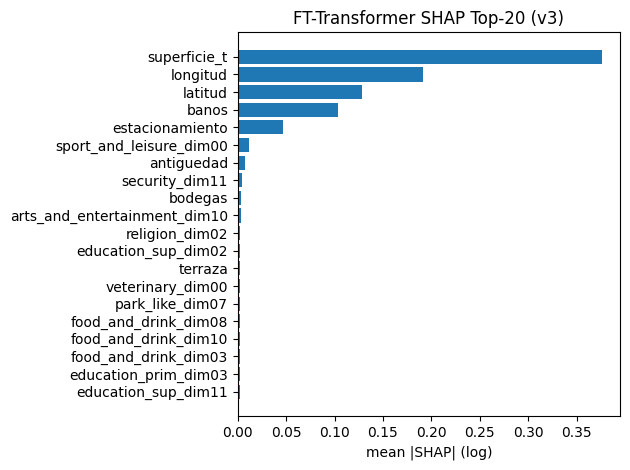

In [18]:
# Gráfico Top-K
plt.figure()
plt.barh(shap_top_ftt["feature"][::-1], shap_top_ftt["mean_|shap|"][::-1])
plt.xlabel("mean |SHAP| (log)"); plt.title(f"FT-Transformer SHAP Top-{TOPK} ({VERSION_TAG_FTT})")
plt.tight_layout(); plt.show()

In [19]:
#Si bien 12 de las 20 features mas importantes son parte de los VCR, su impacto sigue siendo infimo...